In [230]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyhecdss
from vtools.data.vtime import hours
from vtools.functions.filter import cosine_lanczos
import altair as alt
from tabulate import tabulate


In [8]:
def load_dss(dss_file,run_list, C_part):
    '''
    Load dss files and output dataframe
    Parameters
    ----------
    dss_file : str
        filename and path of the dss file to load.
    run_list : LIST
        List of the station names wanted in the dataframe.
    C_part : str
        Name of the part C wanted, i.e. 'STAGE' or 'FLOW'.

    Returns
    -------
    temp : dataframe
        dataframe containing the time serie for the stations specified..

    '''
    
    temp = pd.DataFrame()
    # read dss catalog
    with pyhecdss.DSSFile(dss_file) as d:
         df=d.read_catalog()
    sites = df['B'].where(df['C']==C_part).dropna()
    common_sites = list(set(run_list).intersection(set(sites)))
    catdf = df[df['B'].isin(common_sites)] # filter by needed observation stations
    catdf.reset_index(drop=True, inplace=True)

    if C_part == 'STAGE':
        cat = catdf[catdf['C']=='STAGE']
        plists=d.get_pathnames(cat) # that's the list of ts paths
        for i, plist in enumerate(plists):  
            temp[i],units1,ptype1=d.read_rts(plist) # couldn't figure out how to do it without iterating 
            #print(i, plist)

    if C_part == 'FLOW':
        cat = catdf[catdf['C']=='FLOW']
        plists=d.get_pathnames(cat) # that's the list of ts paths
        for i, plist in enumerate(plists):  
            temp[i],units1,ptype1=d.read_rts(plist)
            
    if C_part == 'EC':
        cat = catdf[catdf['C']=='EC']
        plists=d.get_pathnames(cat) # that's the list of ts paths
        for i, plist in enumerate(plists):  
            temp[i],units1,ptype1=d.read_rts(plist) 
        #print(i, plist)
        
    if C_part == 'DEVICE-FLOW':
        cat = catdf[catdf['C']=='DEVICE-FLOW']
        plists=d.get_pathnames(cat) # that's the list of ts paths
        for i, plist in enumerate(plists):  
            temp[i],units1,ptype1=d.read_rts(plist) 
            #print(i, plist)
            
    if C_part == 'ELEV':
        cat = catdf[catdf['C']=='ELEV']
        plists=d.get_pathnames(cat) # that's the list of ts paths
        for i, plist in enumerate(plists):  
            temp[i],units1,ptype1=d.read_rts(plist) 
            #print(i, plist)    
    #A = cat.B.str.replace('GLC2','GLC',regex=True)
    #B = A.str.replace('VCU2','VCU',regex=True)
    temp.columns = cat.B
    
    #temp = temp[common_sites]

    print(dss_file, C_part)
    temp.info()
    return temp


In [9]:
#%% Load data
# leg1 = 'Modeled Historical (H2M)'
leg1 = 'Modeled Historical (H1Z)'
scenario = 'FPV2Ma'

# For now I'll change it by hand but later will read it from echo file
gatef = {'name' : ['GrantLine','MiddleRiver','OldRiver'],
         'width' : [5,5,5],
         'C' : [0.8,0.8,0.8],
         'bottom_elev' :[-6,-5,-7],
         'ID': ['GLC','MID','OLD'],
         'station' : ['DGL','MHO','OLD']}

fig_folder = r'postpro\fig'
fig_name = scenario+'_compv1_%s.png'
save_fig = True
year = '2021'
leg2 = scenario

stime = '%s-01-01'%year
etime = '%s-12-31'%year

# Scenario Developped
hydro2 = r'.\studies\{}\output\{}_hydro.dss'.format(scenario, scenario)
SDG2 = r'.\studies\{}\output\{}_SDG.dss'.format(scenario, scenario)


# Baseline run for hydro comparison
# hydro1 = r'.\studies\H2M\output\H2M_hydro.dss'
#gtm1 = r'../plan_studies/PRIO_og/output/PRIO_og_gtm.dss'
# SDG1 = r'..\studies\H2M\output\H2M_SDG.dss'

hydro1 = r'.\studies\H2M\output\H1Z_0_hydro.dss'
SDG1 = r'..\studies\H2M\output\H1Z_0_CCF.dss'



In [10]:
# #observed WL
# stage_fn = r'.\zz_compare\data\merged_elev_data_2016_2024.csv'
# stage_data = pd.read_csv(stage_fn,index_col=['Unnamed: 0'],parse_dates=True)
# stage_data = stage_data.asfreq('15min')
# stage_data = stage_data[(stage_data.index>=stime) & (stage_data.index<=etime)]
# stage_sites = stage_data.columns.str.upper()
# stage_data.columns = stage_sites
# stage_data2 = stage_data[['DGL','MHR','OLD']]
# stage_data2 = stage_data2.rename(columns={'MHR':'MHO'})
# stage_data2 = stage_data2.interpolate(limit=4)
# stage_DM = stage_data2.resample('1D').min()



In [11]:
# load data for Velocity analysis
C_part = 'STAGE' # 
elev_list =['MID_GATE_UP','MID_GATE_DOWN','GLC_GATE_UP','GLC_GATE_DOWN','OLD_GATE_UP','OLD_GATE_DOWN']
flow_list = ['GLC_FLOW_FISH','MID_FLOW_FISH','MID_FLOW_GATE','OLD_FLOW_FISH','OLD_FLOW_GATE']

#sc1_stage = load_dss(SDG1,elev_list, C_part)
sc2_stage = load_dss(SDG2,elev_list, C_part)
sc2_stage = sc2_stage[stime:etime]

C_part = 'DEVICE-FLOW'
#sc1_flow= load_dss(SDG1,flow_list, C_part)
sc2_flow = load_dss(SDG2,flow_list, C_part)
sc2_flow = sc2_flow[stime:etime]

# Load data for WL compliance
C_part = 'STAGE' # 
stn_name = ['MHO','DGL','OLD']
stn_thr = [2.5,2.3,2.3]

sc1_wl = load_dss(hydro1,stn_name, C_part)
sc2_wl  = load_dss(hydro2,stn_name, C_part)
sc1_wl = sc1_wl[stime:etime]
sc2_wl = sc2_wl[stime:etime]

# Load Gate OP
C_part = 'ELEV' # 
stn_list =['MID_GATEOP','GLC_GATEOP','OLD_GATEOP']
#sc1_flow= load_dss(SDG1,flow_list, C_part)
sc2_gateop = load_dss(SDG2,stn_list, C_part)
sc2_gateop = sc2_gateop[stime:etime]
sc2_gateop.rename(columns={'MID_GATEOP':'MHO','GLC_GATEOP':'DGL','OLD_GATEOP':'OLD'}, inplace=True) # renaming to make it easier later.



.\studies\FPV2Ma\output\FPV2Ma_SDG.dss STAGE
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280512 entries, 2016-01-01 00:00:00 to 2023-12-31 23:45:00
Freq: 15min
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GLC_GATE_DOWN  280512 non-null  float64
 1   GLC_GATE_UP    280512 non-null  float64
 2   MID_GATE_DOWN  280512 non-null  float64
 3   MID_GATE_UP    280512 non-null  float64
 4   OLD_GATE_DOWN  280512 non-null  float64
 5   OLD_GATE_UP    280512 non-null  float64
dtypes: float64(6)
memory usage: 15.0 MB
.\studies\FPV2Ma\output\FPV2Ma_SDG.dss DEVICE-FLOW
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280512 entries, 2016-01-01 00:00:00 to 2023-12-31 23:45:00
Freq: 15min
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GLC_FLOW_FISH  280512 non-null  float64
 1   MID_FLOW_FISH  280512 non-null  float64
 2   MID_FL

In [12]:
thr_vel = 8
mask = (sc2_flow.index.month>=5) & (sc2_flow.index.month<12) # time when gate are in operation

# Make velocity df

def calc_vel(flow,stage_up, bottom_elev, width):
    #velocity is flow/cross-section
    xs = (stage_up-bottom_elev)*width
    vel = flow/xs
    return vel

vel=pd.DataFrame()
vel['GLC'] = calc_vel(sc2_flow.GLC_FLOW_FISH,sc2_stage.GLC_GATE_UP,gatef['bottom_elev'][0], gatef['width'][0] )
vel['MID'] = calc_vel(sc2_flow.MID_FLOW_FISH,sc2_stage.MID_GATE_UP,gatef['bottom_elev'][1], gatef['width'][1] )
vel['OLD'] = calc_vel(sc2_flow.OLD_FLOW_FISH,sc2_stage.OLD_GATE_UP,gatef['bottom_elev'][2], gatef['width'][2] )



In [13]:
# count the consecutive time velocity is above 8ft/s
vel_cat=pd.DataFrame()
# Replace values below 8 with 0 and above 8 with 1
vel_cat = vel.applymap(lambda x: 0 if x < thr_vel else 1)
vel_cat_op = vel_cat[mask]
# Count consecutive identical values
def count_consecutive(df, column):
    df['group'] = (df[column] != df[column].shift()).cumsum()
    df['original_index'] = df.index
    group_centers = df.groupby('group')['original_index'].apply(lambda x: x.iloc[len(x) // 2])

    result = df.groupby(['group', column]).size().reset_index(name='count')
    result['hours'] = result[column] * result['count'] / 4 # data is every 15 min. so 4 per hour
    result['hours'] = result['hours'].replace(0, np.nan)
    result['original_index'] = group_centers.values
    result.set_index('original_index', inplace=True) # column with consecutive time
    nb_hours_vel_above = result.hours.dropna()
    return nb_hours_vel_above # this is consecutive time

nb_hours_perday_vel_above = vel_cat_op.resample('1D').sum()/4 # hours/day
nb_hours_perday_vel_below = 24-nb_hours_perday_vel_above
avg_nb_hours_perday_vel_above = nb_hours_perday_vel_above.mean().round(1)  # hours/day
avg_nb_hours_perday_vel_below = nb_hours_perday_vel_below.mean().round(1)  # hours/day


C:\Users\Inigo\AppData\Local\Temp\ipykernel_5996\3408789057.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vel_cat = vel.applymap(lambda x: 0 if x < thr_vel else 1)


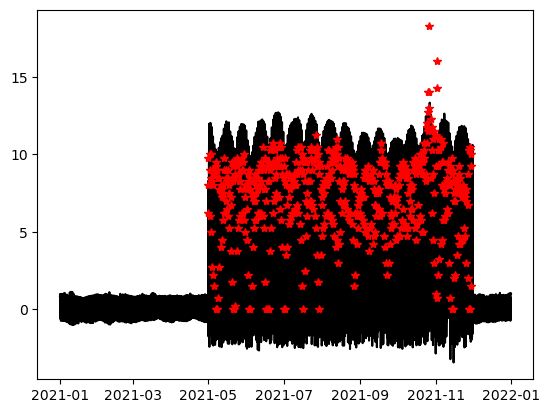

In [14]:
plt.figure()
plt.plot(vel.GLC,'k')
plt.plot(nb_hours_perday_vel_above,'r*')


In [15]:
# flag this for later. Time when gates are in operation =1
vel['in_op'] = 0
vel.loc[mask,'in_op'] = 1

# process stage
daily_min_s1 = sc1_wl.resample('D').min()
daily_min_s2 = sc2_wl.resample('D').min()
daily_min_s2['in_op'] = 0
maskD = (daily_min_s2.index.month>=5) & (daily_min_s2.index.month<12) # time when gate are in operation
daily_min_s2.loc[maskD,'in_op'] = 1
avg_daily_min = daily_min_s2[maskD].mean().round(2)

def out_of_compliance(df,thr,stn,mask):
    dfA = df[stn] # Just get that location
    A = (dfA[mask]<thr) # True when below threshold during OP period
    nb_point=A.count()
    nb_days = A.sum()
    pc_below = nb_days/nb_point*100 # % of days that are below thr
    return(nb_days, pc_below)


# Count how long the gate  is open
sc2_gateop2 = sc2_gateop.applymap(lambda x: 1 if x == 10 else 0) # 1 when close
time_open = ((sc2_gateop2 == 0).resample('D').sum())/4 # number of hours per day the date is open
time_open=time_open[maskD]
time_open_avg=time_open.mean().round(1)


C:\Users\Inigo\AppData\Local\Temp\ipykernel_5996\3981159728.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sc2_gateop2 = sc2_gateop.applymap(lambda x: 1 if x == 10 else 0) # 1 when close


In [16]:
#%% Figure specs
plt.style.use('seaborn-v0_8-talk')

plt.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16,'axes.titlesize':18 })

bn = 10

color2="#3399FF" 
color1= "#FF9933"

pl_arg1 = {'color' : 'black','linewidth' : 1, 'label':leg1}
pl_arg2 = {'color': 'tomato', 'alpha':1, 'linewidth' : 2, 'label':leg2}

y_hist = 50

thelist=gatef['station']


C:\Users\Inigo\AppData\Local\Temp\ipykernel_5996\3408789057.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = (df[column] != df[column].shift()).cumsum()
C:\Users\Inigo\AppData\Local\Temp\ipykernel_5996\3408789057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_index'] = df.index
C:\Users\Inigo\AppData\Local\Temp\ipykernel_5996\3150414516.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored wh

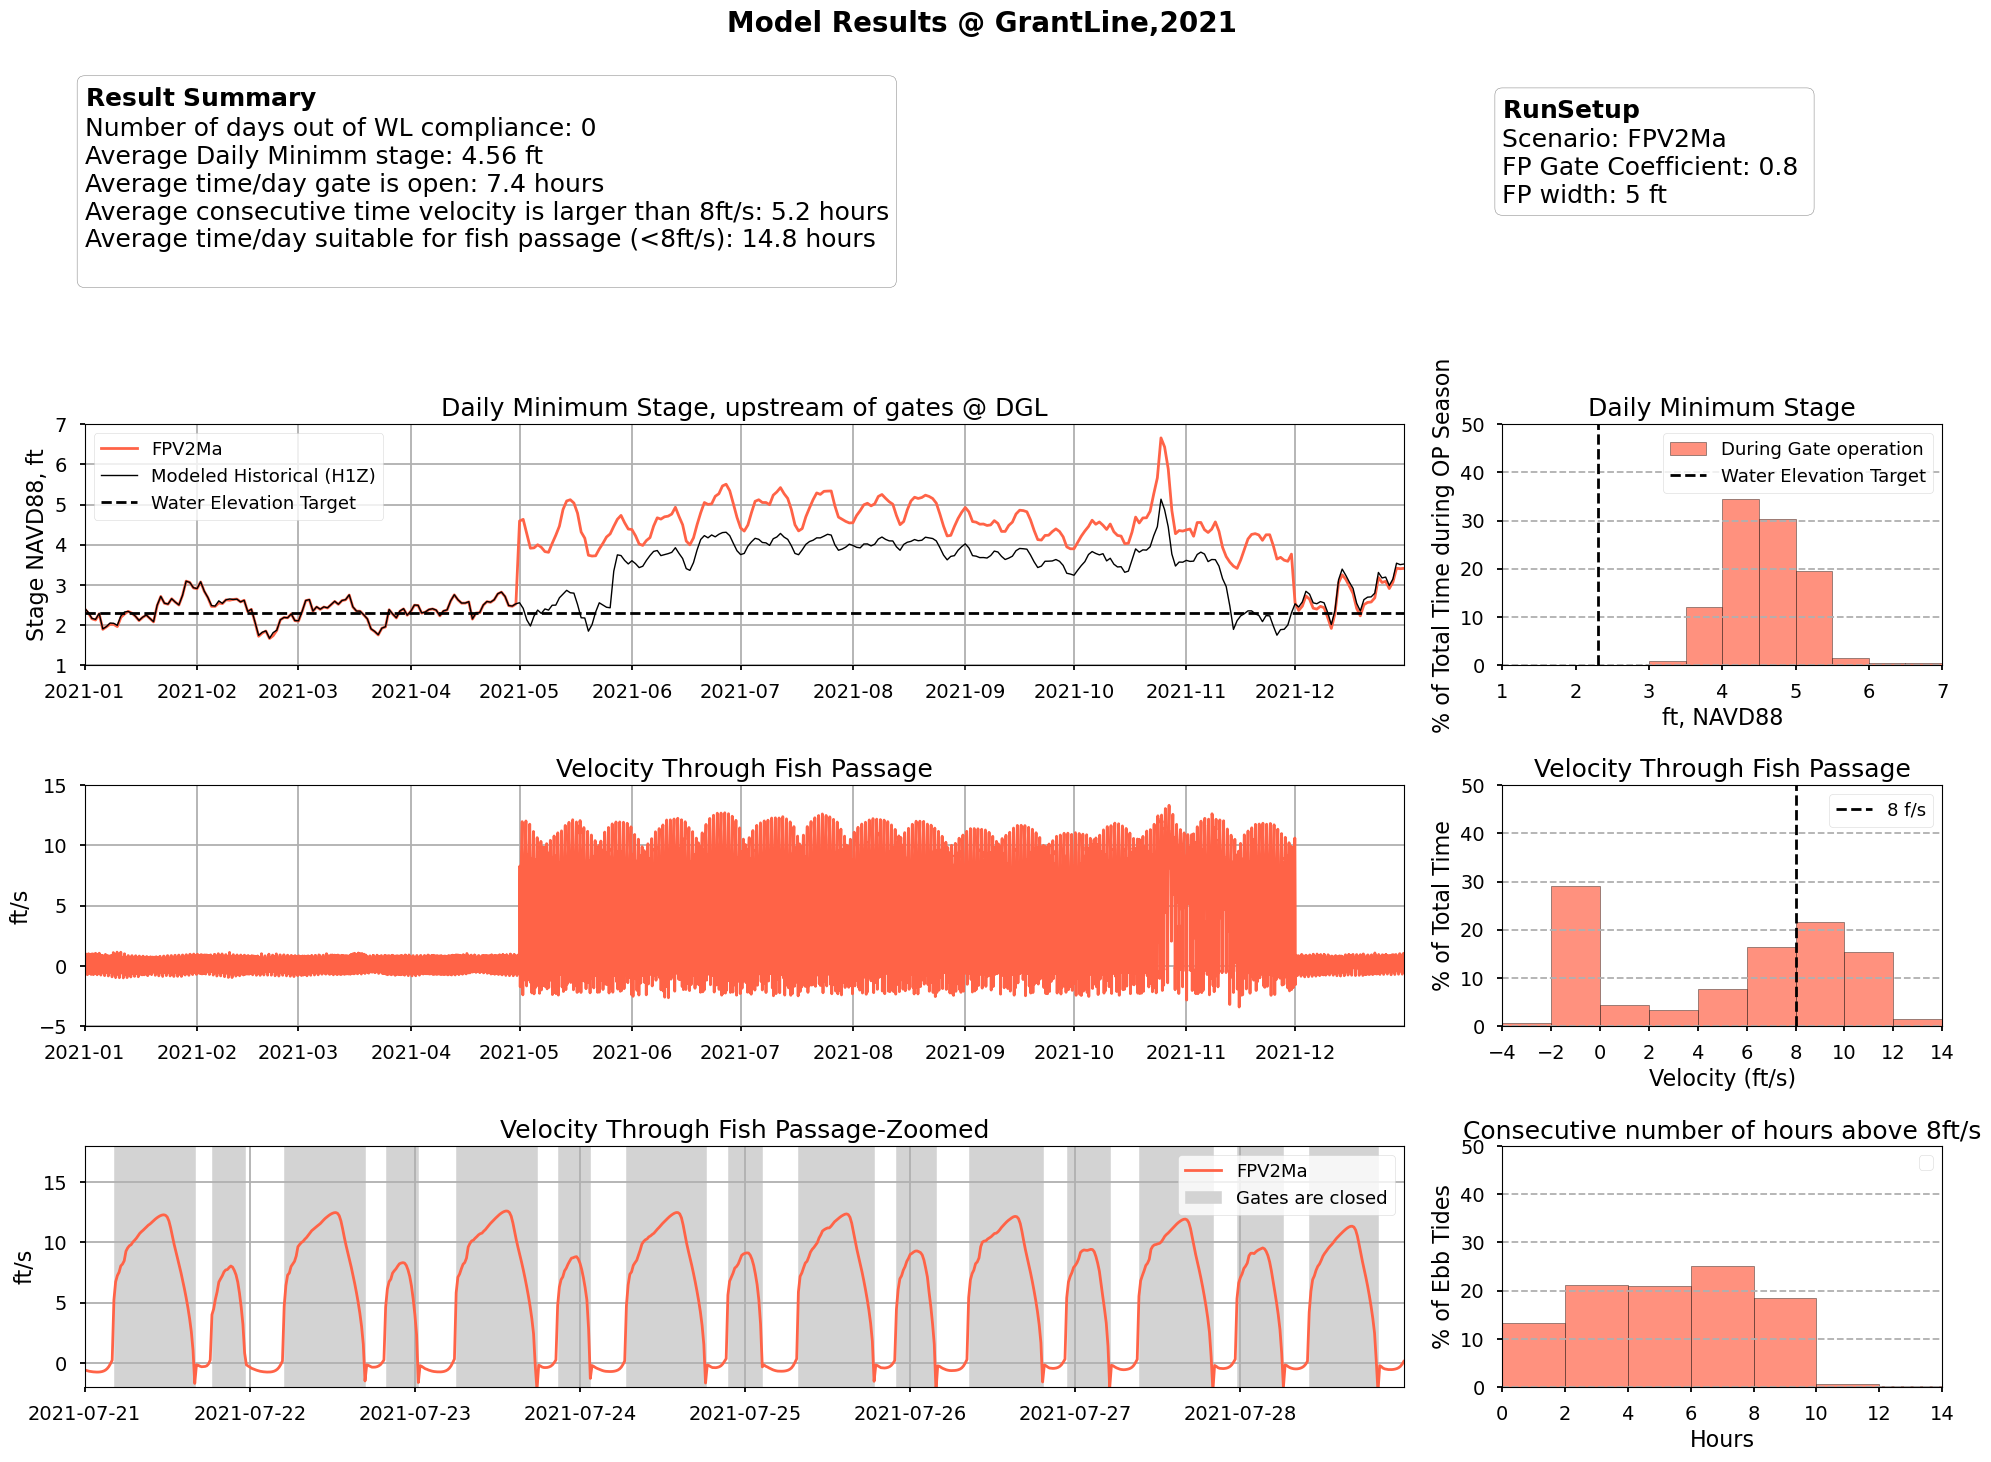

In [17]:
# for j, station in enumerate(thelist): # I suck at this, one day i'll get an handle on iterating with dictionary. Today is not the day.
j = 0
station = "DGL"
fig2, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15), gridspec_kw={'width_ratios': [3, 1]})

# station='DGL'
# j=0
target =2.3
if station=='MHO':
    target=2.5
gate_loc = gatef['ID'][j]
name = gatef['name'][j]
# number of days out of compliance
nb_day_wl, pc_below_wl = out_of_compliance(daily_min_s2,target,station,maskD)
# number of hours above 8ft/s
nb_hours_vel_above = count_consecutive(vel_cat_op, gate_loc)
avg_nb_hours_vel_above = round(nb_hours_vel_above.mean(), 1)
nb_hours_vel_below = 24-nb_hours_vel_above
avg_nb_hours_vel_below = round(nb_hours_vel_below.mean(), 1)


fig2.suptitle('Model Results @ '+name+',%s'%year,fontsize=20,fontweight='bold')

ax[0,0].axis('off')
ax[0,1].axis('off')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
   
summary_text = f'''$\\mathbf{{Result\ Summary}}$
Number of days out of WL compliance: {nb_day_wl}
Average Daily Minimm stage: {avg_daily_min[station]} ft
Average time/day gate is open: {time_open_avg[station]} hours
Average consecutive time velocity is larger than 8ft/s: {avg_nb_hours_vel_above} hours
Average time/day suitable for fish passage (<8ft/s): {avg_nb_hours_perday_vel_below[gate_loc]} hours
'''
ax[0,0].text(0.0, 0.1,summary_text , ha="left", va="bottom", size=18,bbox=bbox_props)

text_run_spec = f'$\\mathbf{{Run Setup}}$\nScenario: {leg2} \nFP Gate Coefficient: {gatef["C"][j]} \nFP width: {gatef["width"][j]} ft'
ax[0,1].text(0.0, 0.4,text_run_spec , ha="left", va="bottom", size=18,bbox=bbox_props)

# Stage monthly min
ax[1,0].set_title('Daily Minimum Stage, upstream of gates @ %s'%station)
# ax[1,0].plot(stage_DM[station], "k:", alpha=0.5,label='Observed Water level')
ax[1,0].plot(daily_min_s2[station],**pl_arg2)
ax[1,0].plot(daily_min_s1[station], **pl_arg1)
ax[1,0].hlines(target,daily_min_s2.index[0],daily_min_s2.index[-1], color ='black', linestyle = 'dashed',linewidth = 2,label = 'Water Elevation Target')
ax[1,0].set_ylabel('Stage NAVD88, ft')
ax[1,0].set_xlim(daily_min_s2.index.min(),daily_min_s2.index.max())
ax[1,0].set_ylim([1,7])
ax[1,0].grid(True)
ax[1,0].legend()

stage_m = daily_min_s2[station].where(daily_min_s2.in_op==1).dropna()
bin_edge = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
ax[1,1].set_title('Daily Minimum Stage')
ax[1,1].hist(stage_m, weights=[(1/len(stage_m)) * 100]*len(stage_m), edgecolor='black', bins=bin_edge, alpha=0.7, color='tomato',label='During Gate operation')
#ax[0,1].hist(daily_min_s2[station].where(daily_min_s2.in_op==0), density=True, edgecolor='black', bins=bn, alpha=0.5, color='black',label='Outside Gate operation')
ax[1,1].vlines(target,0,y_hist, color ='black', linestyle = 'dashed',linewidth = 2,label = 'Water Elevation Target')
ax[1,1].grid(False)
ax[1,1].yaxis.grid(True, linestyle='--')
ax[1,1].set_xlabel('ft, NAVD88')
ax[1,1].set_ylabel('% of Total Time during OP Season')
ax[1,1].set_ylim([0,y_hist])
ax[1,1].set_xlim([1,6])
ax[1,1].set_xticks([1,2,3,4,5,6,7])
ax[1,1].yaxis.grid(True, linestyle='--')
ax[1,1].legend()

# velocity

ax[2,0].set_title('Velocity Through Fish Passage')
ax[2,0].plot(vel[gate_loc], **pl_arg2)
ax[2,0].set_ylabel('ft/s')
ax[2,0].set_ylim([-5,15])
ax[2,0].grid(True)
ax[2,0].set_xlim(daily_min_s2.index.min(),daily_min_s2.index.max())
#ax[1,0].legend()

df_vel = vel[gate_loc].where(vel.in_op==1).dropna()
bin_edge = [-4,-2,0,2,4,6,8,10,12,14]
ax[2,1].set_xticks(bin_edge)
ax[2,1].yaxis.grid(True, linestyle='--')
ax[2,1].set_title('Velocity Through Fish Passage')
ax[2,1].hist(df_vel, bins=bin_edge, weights=[(1/len(df_vel)) * 100]*len(df_vel), edgecolor='black',alpha=0.7, color='tomato')
#ax[1,1].hist(vel[gate_loc].where(vel.in_op==1), histtype="stepfilled", bins=bn, alpha=0.7, color='tomato', label='During Gate operation')
#ax[1,1].hist(vel[gate_loc].where(vel.in_op==0), histtype="stepfilled", bins=bn, alpha=0.5, color='black', label='Outside Gate operation')
ax[2,1].set_xlabel('Velocity (ft/s)')
ax[2,1].set_ylabel('% of Total Time')
ax[2,1].vlines(8,0,y_hist, color ='black', linestyle = 'dashed',linewidth = 2,label = '8 f/s')
ax[2,1].set_ylim([0,y_hist])
ax[2,1].set_xlim([-4,14])
ax[2,1].legend()



# velocity - zoomed in
start_zoom = '%s-07-21'%year
end_zoom = '%s-07-28'%year
gate_up = (sc2_gateop.iloc[:,j] >= 10)
vel_zoom = vel[gate_loc][start_zoom:end_zoom]
ax[3,0].set_title('Velocity Through Fish Passage-Zoomed')
ax[3,0].plot(vel_zoom, **pl_arg2)
ax[3,0].fill_between(sc2_gateop[start_zoom:end_zoom].index, -2, 18, where=gate_up[start_zoom:end_zoom], color='lightgrey', label='Gates are closed')
ax[3,0].set_ylim([-2,18])
ax[3,0].set_ylabel('ft/s')
ax[3,0].legend()
ax[3,0].set_xlim(vel_zoom.index.min(),vel_zoom.index.max())
ax[3,0].grid(True)

bin_edge = [0,2,4,6,8,10,12,14]
if nb_hours_vel_above.empty:
    avg_nb_hours_vel_above = 0
    ax[3,1].set_title('Consecutive number of hours above 8ft/s')
    ax[3,1].set_xlabel('Hours')
    ax[3,1].set_ylabel('% of Ebb Tides')
    ax[3,1].legend()
    ax[3,1].grid(False)
    ax[3,1].set_ylim([0,y_hist])
    ax[3,1].set_xlim([0,18])
    plt.tight_layout(pad=2)
    plt.show()
else:
    avg_nb_hours_vel_above = round(nb_hours_vel_above.mean(), 2)
    ax[3,1].set_title('Consecutive number of hours above 8ft/s')
    ax[3,1].hist(nb_hours_vel_above, bins=bin_edge, weights=[(1/len(nb_hours_vel_above)) * 100]*len(nb_hours_vel_above),edgecolor='black', alpha=0.7, color='tomato')
    ax[3,1].set_xlabel('Hours')
    ax[3,1].set_ylabel('% of Ebb Tides')
    ax[3,1].legend()
    ax[3,1].grid(False)
    ax[3,1].set_ylim([0,y_hist])
    ax[3,1].set_xlim([0,14])
    ax[3,1].set_xticks(bin_edge)
    ax[3,1].yaxis.grid(True, linestyle='--')

plt.tight_layout(pad=2)
plt.show()

In [247]:
start_zoom = '%s-07-21'%year
end_zoom = '%s-07-28'%year
gate_up = (sc2_gateop.iloc[:,j] >= 10)
vel_zoom = vel[gate_loc][start_zoom:end_zoom]
# print(vel_zoom)
vel_zoom_df = pd.DataFrame(vel_zoom)
vel_zoom_df['datetime'] = vel_zoom_df.index
# vel_zoom_df['Over_8ft/s'] = np.where(vel_zoom_df['GLC']>=8, vel_zoom_df['GLC'], np.nan)
# vel_zoom_df['Under_8ft/s'] = np.where(vel_zoom_df['GLC']<8, vel_zoom_df['GLC'], np.nan)

# vel_zoom_df['GLC_Over_Under']= np.where(vel_zoom_df['GLC']>=8, "Over", "Under")
# vel_zoom_df_melt = vel_zoom_df.melt(id_vars=['datetime', 'GLC',],value_vars = ['Over_8ft/s', 'Under_8ft/s'],value_name = 'ft/s', var_name="Velocities Through Passage Zone")

#To count proportion
vel_zoom_df['Velocity_Category'] = np.where(vel_zoom_df['GLC'] >= 8, "Over 8ft/s", "Under 8ft/s")
#.shift shift value down and compare each value with the previous row; increase value when rows are different
vel_zoom_df['consecutive_group'] = (vel_zoom_df['Velocity_Category'] != vel_zoom_df['Velocity_Category'].shift()).cumsum()
vel_zoom_df['date'] = vel_zoom_df['datetime'].dt.date
consecutive_streaks = vel_zoom_df.groupby(['consecutive_group', 'Velocity_Category', 'date']).size().reset_index(name='count')
consecutive_streaks['streak_duration'] = consecutive_streaks['count'] * 15 / 60
# print(consecutive_streaks)
# Filter only meaningful consecutive streaks (where values stay consistent)
over_streaks = consecutive_streaks[consecutive_streaks['Velocity_Category'] == 'Over 8ft/s']
under_streaks = consecutive_streaks[consecutive_streaks['Velocity_Category'] == 'Under 8ft/s']

# Total duration for over and under 8ft/s
total_over_duration = over_streaks['count'].sum()
total_under_duration = under_streaks['count'].sum()

over_streak_duration =  over_streaks['count'] * 15 / 60
under_streak_duration = under_streaks['count'] * 15 / 60
# print(over_streak_duration)
# Group by the Velocity Category and count the number of days in each category
vel_count_df = vel_zoom_df.groupby('Velocity_Category').size().reset_index(name='count')

total_time_df = pd.DataFrame({
    'Velocity_Category': ['Over 8ft/s', 'Under 8ft/s'],
    'Total Hours': [total_over_duration * 15 / 60, total_under_duration * 15 / 60]
})


print(consecutive_streaks)

    consecutive_group Velocity_Category date         count  streak_duration
0    1                 Under 8ft/s       2021-07-21  21    5.25            
1    2                  Over 8ft/s       2021-07-21  35    8.75            
2    3                 Under 8ft/s       2021-07-21  29    7.25            
3    4                  Over 8ft/s       2021-07-21   1    0.25            
4    5                 Under 8ft/s       2021-07-21  10    2.50            
5    5                 Under 8ft/s       2021-07-22  24    6.00            
6    6                  Over 8ft/s       2021-07-22  35    8.75            
7    7                 Under 8ft/s       2021-07-22  27    6.75            
8    8                  Over 8ft/s       2021-07-22   6    1.50            
9    9                 Under 8ft/s       2021-07-22   4    1.00            
10   9                 Under 8ft/s       2021-07-23  28    7.00            
11  10                  Over 8ft/s       2021-07-23  35    8.75            
12  11      

In [291]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', 1000)        # Adjust the width to fit the DataFrame
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.float_format', '{:.2f}'.format)

gate_up = (sc2_gateop.iloc[:,0] >= 10)
gate_up = gate_up[start_zoom:end_zoom]
gate_up_df = pd.DataFrame(gate_up)
gate_up_df['datetime'] = gate_up_df.index
gate_up_df = gate_up_df.reset_index(drop=True)
gate_up_df['consecutive_group'] = (gate_up_df['DGL'] != gate_up_df['DGL'].shift()).cumsum()
gate_up_df['min_datetime'] = gate_up_df.groupby('consecutive_group')['datetime'].transform('min')
gate_up_df['max_datetime'] = gate_up_df.groupby('consecutive_group')['datetime'].transform('max')
gate_up_df['date'] = gate_up_df['datetime'].dt.date
consecutive_streaks = gate_up_df.groupby(['consecutive_group', 'DGL', 'date', 'min_datetime', 'max_datetime']).size().reset_index(name='count')
print(consecutive_streaks)
# consecutive_streaks['streak_duration'] = consecutive_streaks['count'] * 15 / 60
# print(consecutive_streaks)
consecutive_streaks = consecutive_streaks[consecutive_streaks['date'] == 2021-07-21]

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (489662147.py, line 20)

In [254]:
df_velocity['Category'] = 'Velocity'
df_gate['Category'] = 'Gate'

# Combining both DataFrames
df_time_series = pd.concat([
    df_velocity[['date', 'consecutive_group', 'streak_duration', 'Category', 'Velocity_Category']],
    df_gate[['date', 'consecutive_group', 'streak_duration', 'Category', 'gate_status']]
])

In [158]:
# Enhanced line chart
line = alt.Chart(vel_zoom_df).mark_line(interpolate='monotone').encode(
    x=alt.X('datetime:T', title='Datetime'),
    y=alt.Y('GLC:Q', title='Velocity (ft/s)'),
    # strokeDash=alt.StrokeDash('Velocities Through Passage Zone:N'),
    # color=alt.Color('Velocities Through Passage Zone:N', title='Velocity Zone'),
    tooltip=['datetime:T', 'GLC:Q']
).properties(
    width=400,
    height=300
)
# line

# Rule at 8ft/s with customized stroke and color
yrule = (
    alt.Chart().mark_rule(strokeDash=[12, 6], size=2, color = 'red').encode(
        y=alt.datum(8))
).properties(
    width=400,
    height=300
).encode(
        tooltip=alt.TooltipValue('8 ft/s Threshold')  # Static tooltip for the rule line
    )

total_time_chart = alt.Chart(total_time_df).mark_bar(width=40).encode(
    x=alt.X('Velocity_Category', title='Velocity Category'),
    y=alt.Y('Total Hours:Q', title='Total Duration (hours)'),
    color=alt.Color('Velocity_Category', title='Category', scale=alt.Scale(scheme='category10')),
    tooltip=['Velocity_Category:N', 'Total Hours:Q']
).properties(
    title='Total Time Spent Over and Under 8ft/s',
    width=300,
    height=300
)

# Combine the charts into a single view
time_series = (line + yrule).properties(title='Velocity Time Series Over/Under 8ft/s')
# chart1
streak_hist = alt.Chart(consecutive_streaks).mark_bar().encode(
    x=alt.X('streak_duration:Q', bin=True, title='Consecutive Time Period (hour)'),
    y=alt.Y('count()', title='Number of Streaks'),
    color=alt.Color('Velocity_Category:N', title='Velocity Zone')
).properties(
    title='Distribution of Consecutive Time Periods Over and Under 8ft/s',
    width=400,
    height=300
)


alt.vconcat(time_series, total_time_chart, streak_hist).resolve_scale(color='independent')


alt.VConcatChart(...)

In [ ]:
# ax[3,0].fill_between(sc2_gateop[start_zoom:end_zoom].index, -2, 18, where=gate_up[start_zoom:end_zoom], color='lightgrey', label='Gates are closed')

# highlight = alt.Chart(df).mark_area(opacity=0.3, color='red').encode(
#     x='Time:T',
#     y=alt.Y('Velocity:Q', scale=alt.Scale(domain=(0, 3))),
#     y2=alt.Value(2)
# ).transform_filter(
#     'datum.Velocity > 2'
# )
# velocity_line

# area = alt.Chart(vel_zoom_df_melt).mark_area().encode(
#     x = 'datetime:T',
#     y ='ft/s:Q',
#     color = 'variable:N'
# )
# alt.Chart(source).mark_bar().encode(
#   x="month:T",
#   y="nonfarm_change:Q",
#   color=alt.condition(
#       alt.datum.nonfarm_change > 0,
#       alt.value("steelblue"),  # The positive color
#       alt.value("orange")  # Th
# line = alt.Chart(vel_zoom_df).mark_line().encode(
#     x='datetime:T',
#     y='GLC:Q',
#     strokeDash = 'GLC_Over_Under:N'
# )